In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd

from csv import reader
import skimage
from skimage import io, transform, exposure, data, color
from skimage.color import *

BBBC038 = "/raid/data/BBBC038/"
training_imgs_dir = "/raid/data/BBBC038/training/"

# View sample image

In [2]:
sample_dir = "/raid/data/BBBC038/training/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0/"
# os.listdir(sample_dir + 'masks/')
# io.imshow(sample_dir + 'images/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0.png')

# Load All Data

43c1aed744020c4c255e67d0a17831d0d0e01b670e6ef2d61a935eca47eaf2e6.png
751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49


/opt/tljh/user/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


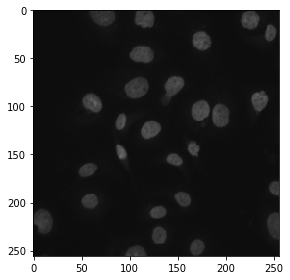

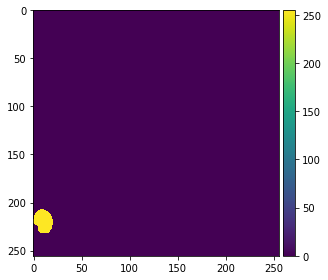

In [3]:
img_paths = []
img_names = []
mask_png_list = []
mask_colls = []

for img_name in os.listdir(training_imgs_dir):
    path_image = f"{training_imgs_dir}/{img_name}/images/{img_name}.png"
    path_masks = f"{training_imgs_dir}/{img_name}/masks/*.png"
    
    mask_coll = io.collection.ImageCollection(path_masks)
    mask_dir = f"{training_imgs_dir}/{img_name}/masks/"
    mask_dir = os.listdir(mask_dir)
    
    mask_colls.append(mask_coll)
    img_paths.append(path_image)
    mask_png_list.append(mask_dir)
    img_names.append(img_name)

# sample
io.imshow(img_paths[0])
plt.figure()
io.imshow(mask_colls[0][0])
print(mask_png_list[0][0])
print(img_names[0])

# Load All Labeled Data

In [4]:
image_groups = pd.read_csv(BBBC038 + "training_classifications.csv")
full_name = []

for i, image_name in image_groups.iterrows():
    full_name.append(image_name)
    
image_groups[image_groups["Type"] == "Purple"]
# full_name[2][1]
# image_groups["Type"].unique()

,Type,Image_Name
566,Purple,0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a389...
567,Purple,7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f4...
568,Purple,ed5be4b63e9506ad64660dd92a098ffcc0325195298c13...
569,Purple,33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4e...
570,Purple,40946065f7e4b6038599fbfd419f2a67e7635b6f89db3e...
...,...,...
665,Purple,a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9...
666,Purple,815524d88283ba10ad597b87aa1967671db776df8004a0...
667,Purple,3b0709483b1e86449cc355bb797e841117ba178c6ae1ed...
668,Purple,1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20...


In [5]:
csv_lines = []
with open(BBBC038 + "training_classifications.csv") as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        csv_lines.append(row)

# Find all Purple images and masks in directory

In [6]:
purple_png_list = []
for row in csv_lines:
    if "Purple" in row:
        purple_png_list.append(row[1])

# len(purple_png_list) # 104, as expected

In [7]:
purple_img_paths = []
for i in range(len(purple_png_list)):
    path = training_imgs_dir + purple_png_list[i][:-4] + "/images/" + purple_png_list[i]
    purple_img_paths.append(path)
    
# len(purple_img_paths)
# samp = io.imread(purple_img_paths[5])
# io.imshow(samp)

In [8]:
purple_masks = []
for i in range(104):
    curr_img_path = training_imgs_dir + purple_png_list[i][:-4] + "/masks/*.png"
    imcoll = io.collection.ImageCollection(curr_img_path)
    purple_masks.append(imcoll)
    
# first index is image collection, second is mask within collection
# io.imshow(purple_masks[3][0])

In [9]:
purp_data = io.imread(purple_img_paths[5])
# io.imshow(purp_data)

# Copy purple images and masks in order to not damage dataset

In [10]:
# purp_copies = []
# copy_paths = []
# mask_copies = []
# copy_imgs_dir = "/raid/data/BBBC038/purp_imgs_copies/"

# for i in range(104):
#     curr_path = training_imgs_dir + purple_png_list[i][:-4]
    
#     # get images, copy them and save them to copy directory
#     purp_img = Image.open(curr_path + "/images/" + purple_png_list[i], 'r')
#     copy = purp_img.copy()
#     copy.save(copy_imgs_dir + purple_png_list[i])
    
#     copy_paths.append(copy_imgs_dir + purple_png_list[i])
#     purp_copies.append(copy)
    
#     # get masks
#     curr_masks_path = curr_path + "/masks/*.png"
#     copy_coll = io.collection.ImageCollection(curr_img_path)
    
#     mask_copies.append(copy_coll)

# Unmix Colors from Purple Images
* use separate stains
* use hamatoxylin and eosin (maybe ponceau fuchsin)
* see which stain(s) produce same output as cell profiler

Cell Profiler's Stain library

In [11]:
CHOICE_HEMATOXYLIN = "Hematoxylin"
ST_HEMATOXYLIN = (0.644, 0.717, 0.267)

CHOICE_EOSIN = "Eosin"
ST_EOSIN = (0.093, 0.954, 0.283)

CHOICE_DAB = "DAB"
ST_DAB = (0.268, 0.570, 0.776)

CHOICE_FAST_RED = "Fast red"
ST_FAST_RED = (0.214, 0.851, 0.478)

CHOICE_FAST_BLUE = "Fast blue"
ST_FAST_BLUE = (0.749, 0.606, 0.267)

CHOICE_METHYL_BLUE = "Methyl blue"
ST_METHYL_BLUE = (0.799, 0.591, 0.105)

CHOICE_METHYL_GREEN = "Methyl green"
ST_METHYL_GREEN = (0.980, 0.144, 0.133)

CHOICE_AEC = "AEC"
ST_AEC = (0.274, 0.679, 0.680)

CHOICE_ANILINE_BLUE = "Aniline blue"
ST_ANILINE_BLUE = (0.853, 0.509, 0.113)

CHOICE_AZOCARMINE = "Azocarmine"
ST_AZOCARMINE = (0.071, 0.977, 0.198)

CHOICE_ALICAN_BLUE = "Alican blue"
ST_ALICAN_BLUE = (0.875, 0.458, 0.158)

CHOICE_PAS = "PAS"
ST_PAS = (0.175, 0.972, 0.155)

CHOICE_HEMATOXYLIN_AND_PAS = "Hematoxylin and PAS"
ST_HEMATOXYLIN_AND_PAS = (0.553, 0.754, 0.354)

CHOICE_FEULGEN = "Feulgen"
ST_FEULGEN = (0.464, 0.830, 0.308)

CHOICE_METHYLENE_BLUE = "Methylene blue"
ST_METHYLENE_BLUE = (0.553, 0.754, 0.354)

CHOICE_ORANGE_G = "Orange-G"
ST_ORANGE_G = (0.107, 0.368, 0.923)

CHOICE_PONCEAU_FUCHSIN = "Ponceau-fuchsin"
ST_PONCEAU_FUCHSIN = (0.100, 0.737, 0.668)

CHOICE_CUSTOM = "Custom"
STAIN_DICTIONARY = {
    CHOICE_AEC: ST_AEC,
    CHOICE_ALICAN_BLUE: ST_ALICAN_BLUE,
    CHOICE_ANILINE_BLUE: ST_ANILINE_BLUE,
    CHOICE_AZOCARMINE: ST_AZOCARMINE,
    CHOICE_DAB: ST_DAB,
    CHOICE_EOSIN: ST_EOSIN,
    CHOICE_FAST_BLUE: ST_FAST_BLUE,
    CHOICE_FAST_RED: ST_FAST_RED,
    CHOICE_FEULGEN: ST_FEULGEN,
    CHOICE_HEMATOXYLIN: ST_HEMATOXYLIN,
    CHOICE_HEMATOXYLIN_AND_PAS: ST_HEMATOXYLIN_AND_PAS,
    CHOICE_METHYL_BLUE: ST_METHYL_BLUE,
    CHOICE_METHYLENE_BLUE: ST_METHYLENE_BLUE,
    CHOICE_METHYL_GREEN: ST_METHYL_GREEN,
    CHOICE_ORANGE_G: ST_ORANGE_G,
    CHOICE_PAS: ST_PAS,
    CHOICE_PONCEAU_FUCHSIN: ST_PONCEAU_FUCHSIN,
}

In [12]:
# io.imshow(copy_paths[1])
read_img = io.imread(purple_img_paths[1])
read_img.shape

(256, 320, 4)

In [13]:
stain_img = read_img[:, :, [0, 1, 2]]
hematoxylin_matrix = np.ones((3,3)) * (0.644, 0.717, 0.267) # cell profiler matrix for purple images
hed_img = separate_stains(stain_img, hematoxylin_matrix)
# hed_img.shape
# print(hematoxylin_matrix)
# print(hed_from_rgb)

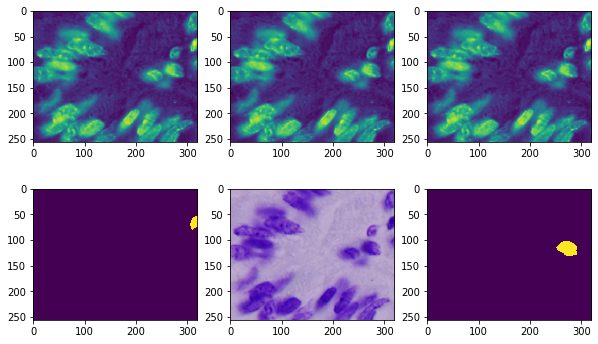

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# ax.set_title('fgx')
ax[0][0].imshow(hed_img[:, :, 0])
ax[0][1].imshow(hed_img[:, :, 1])
ax[0][2].imshow(hed_img[:, :, 2])
ax[1][0].imshow(purple_masks[1][0])
ax[1][1].imshow(stain_img)
ax[1][2].imshow(purple_masks[1][4])

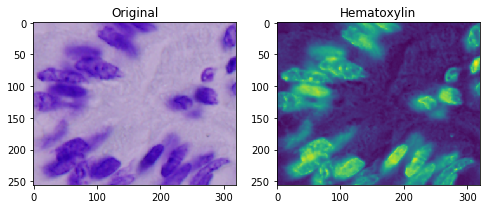

In [15]:
from colors import unmix_purple_img
unmixed_purple = unmix_purple_img(purple_img_paths[1], True)

# Extend Experiment to Pink-Purple Images

In [16]:
pink_png_list = []

for row in csv_lines:
    if "Pink-Purple" in row:
        pink_png_list.append(row[1])

In [17]:
pink_img_paths = []

for i in range(len(pink_png_list)):
    path = training_imgs_dir + pink_png_list[i][:-4] + "/images/" + pink_png_list[i]
    pink_img_paths.append(path)

# io.imshow(pink_img_paths[0])

4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06.png


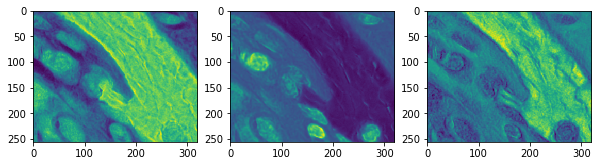

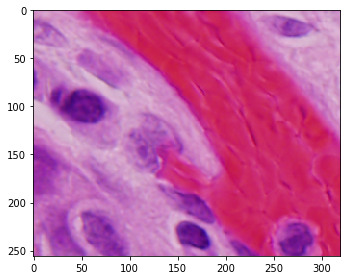

In [18]:
pink_img = io.imread(pink_img_paths[1])
print(pink_png_list[1])
pink_img = pink_img[:, :, [0, 1, 2]]

pink_rbd = separate_stains(pink_img, rbd_from_rgb)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
ax[0].imshow(pink_rbd[:, :, 0])
ax[1].imshow(pink_rbd[:, :, 1])
ax[2].imshow(pink_rbd[:, :, 2])
plt.figure()
io.imshow(pink_img)

* Test quantitative differences between images (array comparisons)

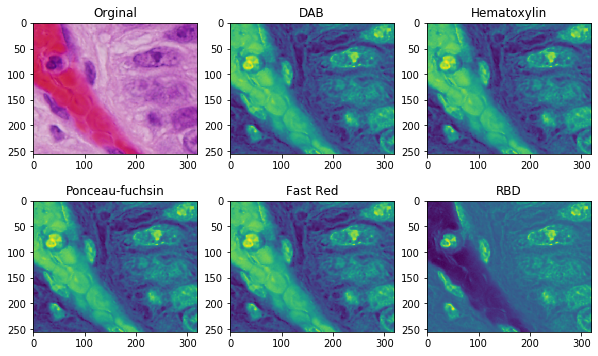

In [19]:
dab_matrix = np.ones((3,3)) * (0.268, 0.570, 0.776)
hematoxylin_matrix = np.ones((3,3)) * (0.644, 0.717, 0.267)
ponceau_matrix = np.ones((3,3)) * (0.100, 0.737, 0.668)
fast_red_matrix = np.ones((3,3)) * (0.214, 0.851, 0.478)
green_matrix = np.ones((3,3)) * (0.980, 0.144, 0.133)

pink_img = io.imread(pink_img_paths[0])
pink_img = pink_img[:, :, :-1]

pink_dab = separate_stains(pink_img, dab_matrix)
pink_hema = separate_stains(pink_img, hematoxylin_matrix)
pink_ponc = separate_stains(pink_img, ponceau_matrix)
pink_fRed = separate_stains(pink_img, fast_red_matrix)
pink_rbd = separate_stains(pink_img, rbd_from_rgb)
pink_green = separate_stains(pink_img, green_matrix)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))

ax[0][0].set_title("Orginal")
ax[0][0].imshow(pink_img)

ax[0][1].set_title("DAB")
ax[0][1].imshow(pink_dab[:, :, 2])

ax[0][2].set_title("Hematoxylin")
ax[0][2].imshow(pink_hema[:, :, 1])

ax[1][0].set_title("Ponceau-fuchsin")
ax[1][0].imshow(pink_ponc[:, :, 0])

ax[1][1].set_title("Fast Red")
ax[1][1].imshow(pink_fRed[:, :, 0])

ax[1][2].set_title("RBD")
ax[1][2].imshow(pink_rbd[:, :, 1])

In [20]:
comparison = pink_dab == pink_hema
is_equal = comparison.all()
print(is_equal)

False


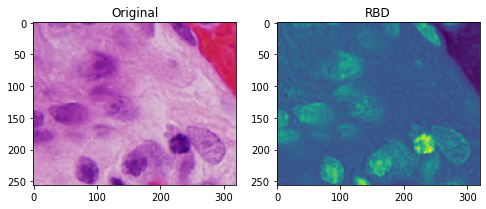

In [21]:
from colors import unmix_pink_imgs
unmixed_pink = unmix_pink_imgs(pink_img_paths[3], True)

# Compute Average Size of Nuclei in an Image

In [23]:
size = 0
for mask in mask_colls[0]:
    size += np.sum(mask != 0)
size = size / len(mask_colls[0])
print(size)

238.93103448275863


In [41]:

def compute_avg_size(img_name, loud=False):
    data_dir = f"{training_imgs_dir}{img_name}/masks/*.png"
    mask_coll = io.collection.ImageCollection(data_dir)
    size = 0
    
    for mask in mask_coll:
        size += np.sum(mask != 0)
        
    size = size / len(mask_coll)
    return size

152.66666666666666


/opt/tljh/user/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


106

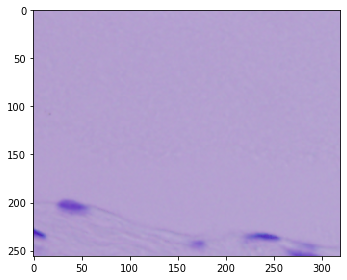

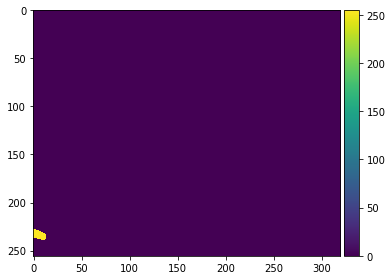

In [42]:
img_name = img_names[100]
msk_name = mask_png_list[100][5][:-4]
print(compute_avg_size(img_name))
io.imshow(img_paths[100])
plt.figure()
io.imshow(f"{training_imgs_dir}{img_name}/masks/{msk_name}.png")
np.sum(io.imread(f"{training_imgs_dir}{img_name}/masks/{msk_name}.png") != 0)

# Composite Mask of Nuclei Into Single Image
* use numpy to concactenate image arrays
* multiply each array by a different number to tell the difference when combining arrays

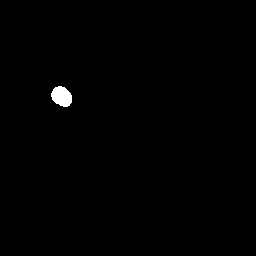

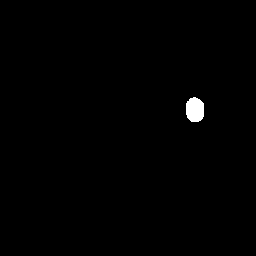

In [27]:
import PIL
from PIL import Image

img = Image.open(img_paths[0])
im1 = Image.open(f"{training_imgs_dir}{img_names[0]}/masks/{mask_png_list[0][0]}")
im2 = Image.open(f"{training_imgs_dir}{img_names[0]}/masks/{mask_png_list[0][4]}")
display(im1); display(im2)

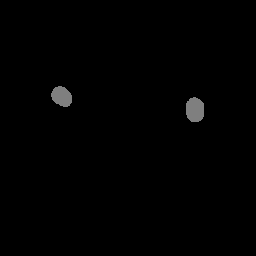

In [28]:
im = Image.blend(im1, im2, .5)
display(im)

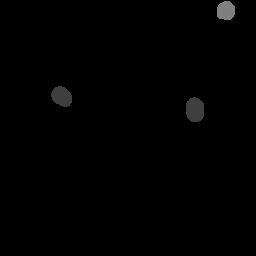

29

In [29]:
im3 = Image.open(f"{training_imgs_dir}{img_names[0]}/masks/{mask_png_list[0][3]}")
im = Image.blend(im, im3, 0.5)
display(im)
len(mask_png_list[0])

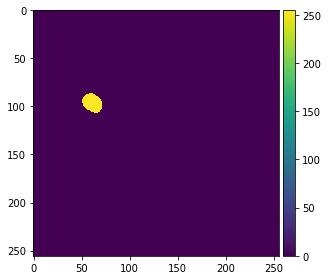

In [30]:
im1 = np.array(im1)
io.imshow(im1)